# Proof of concept of new "composable" ADMM formulation

3/30/21

This notebook is a proof of concept and understanding of how to break apart the class cost function

$$ \phi(x) = \left\lVert Dx \right\rVert_1, $$

Such that the ADMM subproblem for that component has a closed form solution.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [46]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, PiecewiseConstant, SparseFirstDiffConvex, LaplaceNoise, Blank
from osd.generators import proj_l2_d2, make_pwc_data
from osd.utilities import progress

## Problem data generation

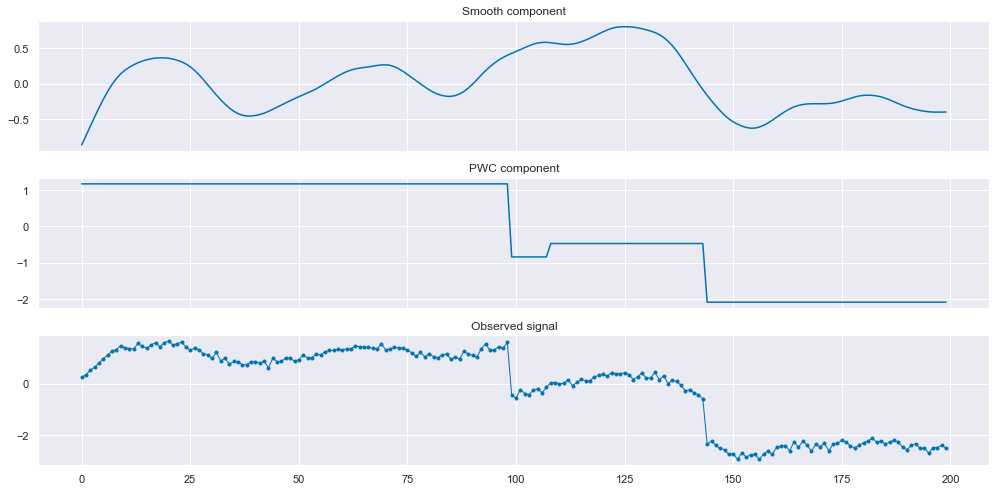

In [5]:
T = 200
X_real = np.zeros((3, T))
X_real[0] = 0.1 * np.random.randn(T)
X_real[1] = proj_l2_d2(np.random.randn(T), theta=5e2) * 2
X_real[2] = make_pwc_data(T, segments=4)
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(X_real[1])
ax[1].set_title('PWC component')
ax[1].plot(X_real[2])
ax[2].set_title('Observed signal')
ax[2].plot(y, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()

In [122]:
def make_consensus_prob(y, X, U):
    Z_var = cvx.Variable(X.shape)
    X_param = cvx.Parameter(X.shape, value=X, name='X')
    U_param = cvx.Parameter(X.shape, value=U, name='U')
    y_param = cvx.Parameter(len(y), value=y, name='y')
    objective = cvx.Minimize(cvx.norm(Z_var - U_param - X_param, 'fro'))
    constraints = [
        cvx.sum(Z_var[:-1, :], axis=0) == y_param,
        cvx.diff(Z_var[2, :], k=1) == Z_var[3, :-1]
    ]
    problem = cvx.Problem(objective, constraints)
    return problem

def calc_obj(y, X, components, use_ix):
    """
    Calculate the current objective value of the problem

    :param y: numpy array containing problem data
    :param X: current estimate of decomposed signal components from ADMM
    :param use_ix: the known index set (Boolean array)
    :return: the scalar problem objective value
    """
    K = len(components)
    X_tilde = make_estimate(y, X, use_ix)
    obj_val = 0
    for k in range(K):
        try:
            cost = components[k].cost(X_tilde[k]).value.item()
        except AttributeError:
            cost = components[k].cost(X_tilde[k])
        theta = components[k].theta
        obj_val += theta * cost
    return obj_val

def make_estimate(y, X, use_ix):
    """
    After any given iteration of the ADMM algorithm, generate an estimate that
    is feasible with respect to the global equality constraint by making x0
    equal to the residual between the input data y and the rest of the
    component estimates

    :param y: numpy array containing problem data
    :param X: current estimate of decomposed signal components from ADMM
    :param use_ix: the known index set (Boolean array)
    :return: the estimate with the first component replaced by the residuals
    """
    X_tilde = np.copy(X)
    X_tilde[0, use_ix] = y - np.sum(X[1:, use_ix], axis=0)
    X_tilde[0, ~use_ix] = 0
    return X_tilde

def run_admm(data, components, num_iter=50, rho=1., use_ix=None, verbose=True,
             randomize_start=False, X_init=None):
    """
    Serial implementation of SD ADMM algorithm.

    :param data: numpy array containing problem data
    :param components: list of osd.components class objects
    :param num_iter: (int) the number of ADMM iterations to perform
    :param rho: (float) the ADMM learning rate
    :param use_ix: (None or Boolean array) the set of known index values
    :param verbose: (Boolean) print progress to screen
    :param randomize_start: (Boolean) Randomize initialization of components
    :return:
    """
    y = data
    T = len(data)
    K = len(components)
    if use_ix is None:
        use_ix = np.ones_like(data, dtype=bool)
    if X_init is None:
        X = np.zeros((K, T))
        if not randomize_start:
            X[0, use_ix] = y[use_ix]
        else:
            X[1:, :] = np.random.randn(K-1, T)
            X[0, use_ix] = y[use_ix] - np.sum(X[1:, use_ix], axis=0)
    elif X_init.shape == (K, T):
        X = np.copy(X_init)
    else:
        m1 = 'A initial value was given for X that does not match the problem shape.'
        print(m1)
        return
    Z = np.copy(X)
    U = np.zeros_like(X)
    residuals = []
    obj_vals = []
    ti = time()
    consensus_problem = make_consensus_prob(y, X, U)
    parameters = {p.name(): p for p in prob.parameters()}
    best = {
        'X': None,
        'u': None,
        'it': None,
        'obj_val': np.inf
    }
    try:
        for it in range(num_iter):
            if verbose:
                td = time() - ti
                progress(it, num_iter, '{:.2f} sec'.format(td))
            # Apply proximal operators for each signal class
            for k in range(K):
                prox = components[k].prox_op
                theta = components[k].theta
                X[k, :] = prox(Z[k, :] - U[k, :], theta, rho)
            # Consensus step
            parameters['X'].value = X
            parameters['U'].value = U
            consensus_problem.solve(solver='MOSEK')
            Z = consensus_problem.variables()[0].value
            # U-update
            U += X - Z
            # mean-square-error
            error = np.sum(X[:-1, use_ix], axis=0) - y[use_ix]
            mse = np.sum(np.power(error, 2)) / error.size
            residuals.append(mse)
            obj_val = calc_obj(y, X, components, use_ix)
            obj_vals.append(obj_val)
            if obj_val < best['obj_val']:
                X_tilde = make_estimate(y, X, use_ix)
                best = {
                    'X': X_tilde,
                    'u': U,
                    'it': it,
                    'obj_val': obj_val
                }
    except error as e:
        print("something failed :(")
        print(e)
    if verbose:
        td = time() - ti
        progress(it + 1, num_iter, '{:.2f} sec\n'.format(td))
    outdict = {
        'X': best['X'],
        'u': best['u'],
        'it': best['it'],
        'residuals': residuals,
        'obj_vals': obj_vals,
        'best_obj': best['obj_val']
    }
    return outdict

In [133]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=1e2)
c3 = Blank()
c4 = LaplaceNoise()


In [140]:
results = run_admm(y, [c1, c2, c3, c4], rho=5, num_iter=500)

[============================================================] 100.0% ...83.49 sec


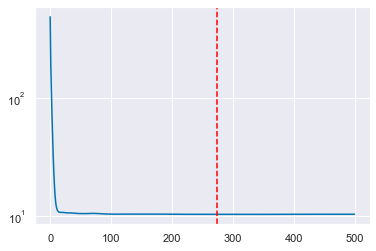

In [141]:
plt.plot(results['obj_vals'])
plt.axvline(results['it'], color='red', ls='--')
plt.yscale('log')

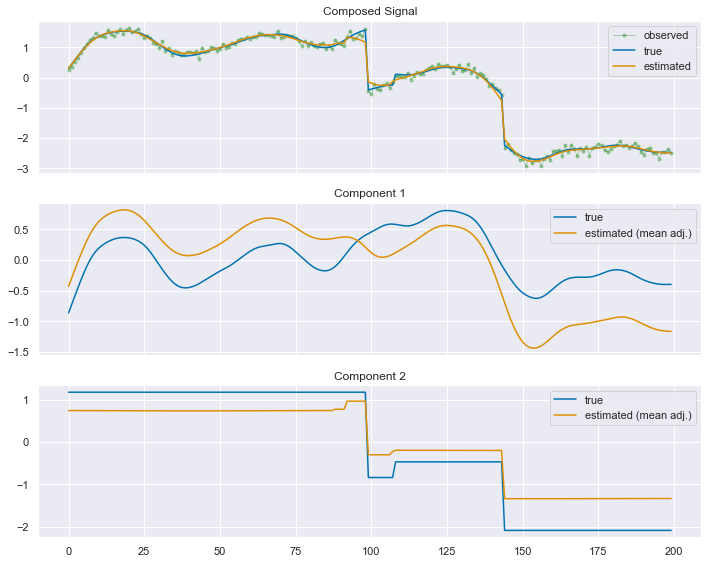

In [143]:
K = 3
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = results['X'][k]
        ax[k].plot(true, label='true')
        ax[k].plot(est, label='estimated (mean adj.)')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(results['X'][1:-1], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()

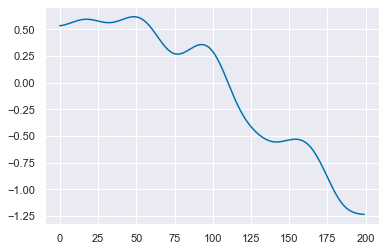

In [132]:
plt.plot(results['X'][2])

## Cardinality-constrained formulation

### Solve with ADMM

In [83]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=1e2)
c3 = PiecewiseConstant(num_segments=4)
components = [c1, c2, c3]
problem = Problem(y, components)

In [84]:
problem.decompose(admm=True, rho=1, num_iter=100)

[============================================================] 100.0% ...26.62 sec


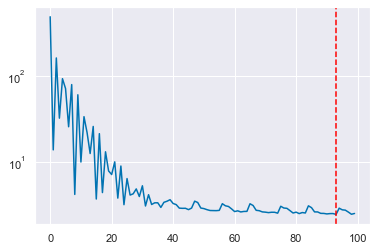

In [85]:
plt.plot(problem.admm_result['obj_vals'])
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')

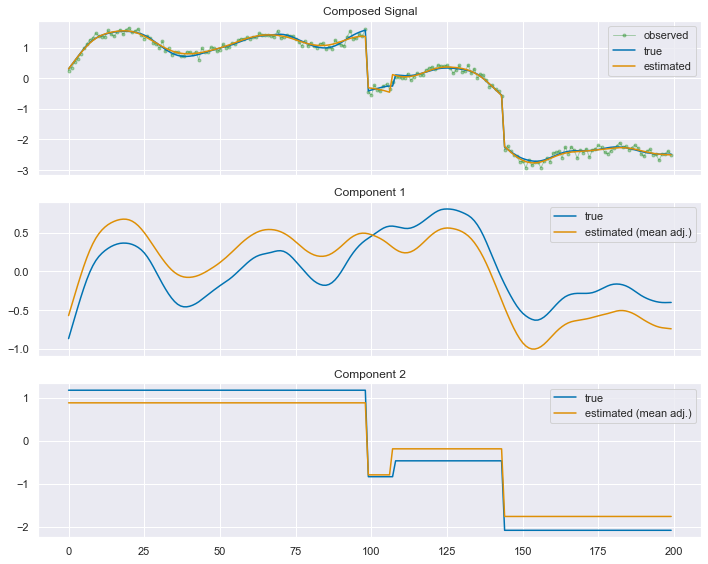

In [86]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true')
        ax[k].plot(est - np.average(est) + np.average(true), label='estimated (mean adj.)')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()

### Solve with CVXPY

In [9]:
problem.decompose(admm=False)

This problem is non-convex and not solvable with CVXPY. Please try solving with ADMM.


In [10]:
print([c.is_convex for c in problem.components])

[True, True, False]


## $\ell_1$-penalized formulation

### Solve with ADMM

In [144]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=1e2)
c3 = SparseFirstDiffConvex(theta=1e0)
components = [c1, c2, c3]
problem = Problem(y, components)

In [145]:
problem.decompose(admm=True, rho=1, num_iter=100)

[============================================================] 100.0% ...5.37 sec


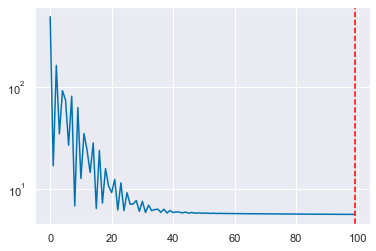

In [146]:
plt.plot(problem.admm_result['obj_vals'])
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')

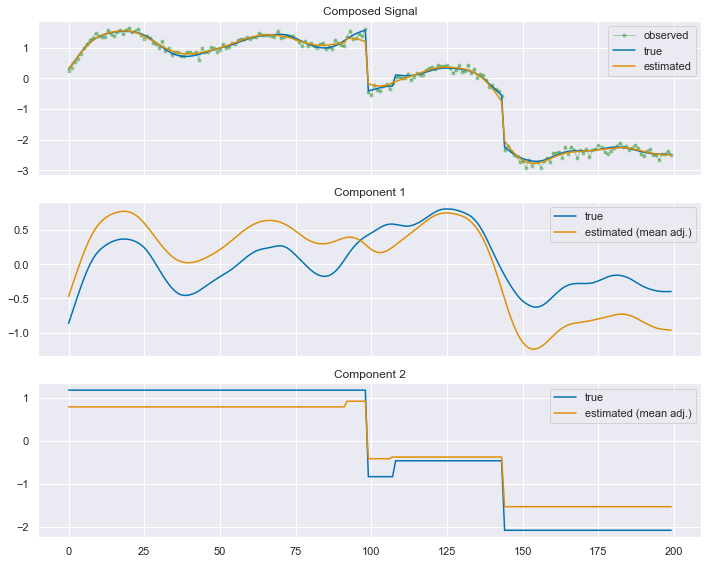

In [147]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true')
        ax[k].plot(est - np.average(est) + np.average(true), label='estimated (mean adj.)')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()

### Solve with CVXPY

In [148]:
problem.weights.value = [c.theta for c in problem.components]
problem.decompose(admm=False, solver='MOSEK')

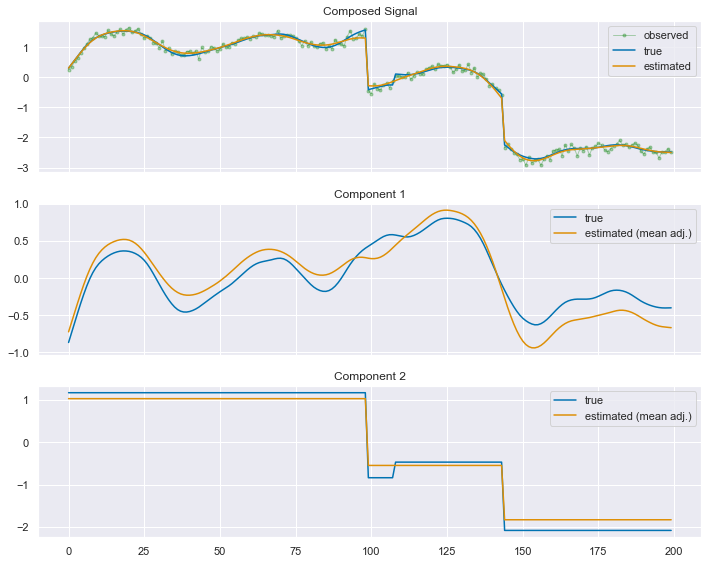

In [149]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true')
        ax[k].plot(est - np.average(est) + np.average(true), label='estimated (mean adj.)')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()